In [1]:
import numpy as np
import pandas as pd
!pip install chardet
import chardet
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 2.6 MB/s eta 0:00:00


In [2]:
with open('/kaggle/input/sms-spam-collection-dataset/spam.csv', 'rb') as f:
    encoding = chardet.detect(f.read())['encoding']

In [3]:
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding=encoding)

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

### Data Cleaning

In [6]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [7]:
df.rename({'v1':'target','v2':'text'},axis=1,inplace=True)

In [8]:
df['target']=df['target'].map({'ham':0,'spam':1})

In [9]:
#checking for duplicate values
df.duplicated().sum()

403

In [10]:
df.drop_duplicates(keep='first',inplace=True)

In [11]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### EDA

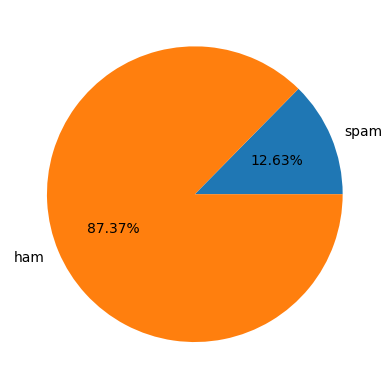

In [12]:
y=[df['target'].sum(),df.shape[0]-df['target'].sum()]
plt.pie(y,labels=['spam','ham'],autopct='%1.2f%%')
plt.show()

In [13]:
import nltk

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
df['num_char']=df['text'].apply(len)

In [16]:
df['num_word']=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [17]:
df['num_sen']=df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [18]:
#for ham
df[df.target==0][['num_char','num_word','num_sen']].describe()

,num_char,num_word,num_sen
count,4516.000000,4516.000000,4516.000000
mean,70.459256,16.957484,1.815545
std,56.358207,13.394052,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,219.000000,38.000000


In [19]:
#for spam
df[df.target==1][['num_char','num_word','num_sen']].describe()
#mean is more for spam messages

,num_char,num_word,num_sen
count,653.000000,653.000000,653.000000
mean,137.891271,27.474732,2.969372
std,30.137753,6.893007,1.488910
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,44.000000,9.000000


In [20]:
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


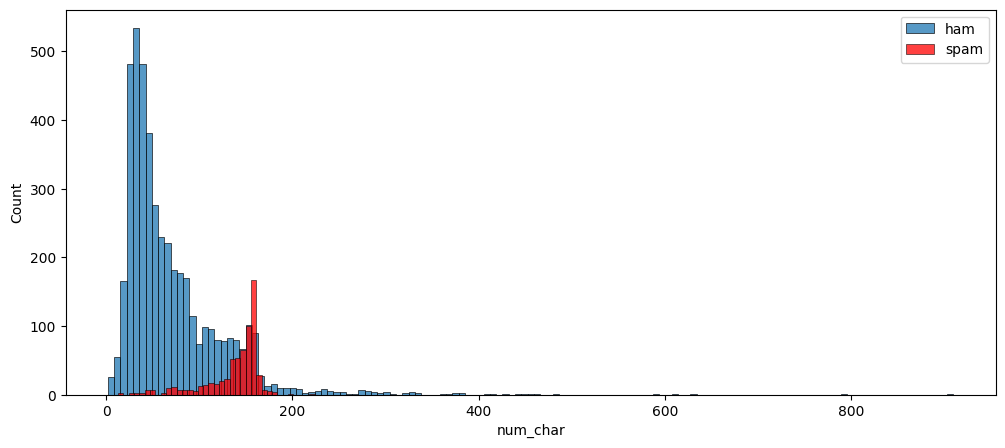

In [21]:
plt.figure(figsize=(12,5))
sns.histplot(df[df.target==0]['num_char'],label='ham')
sns.histplot(df[df.target==1]['num_char'],color='red',label='spam')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


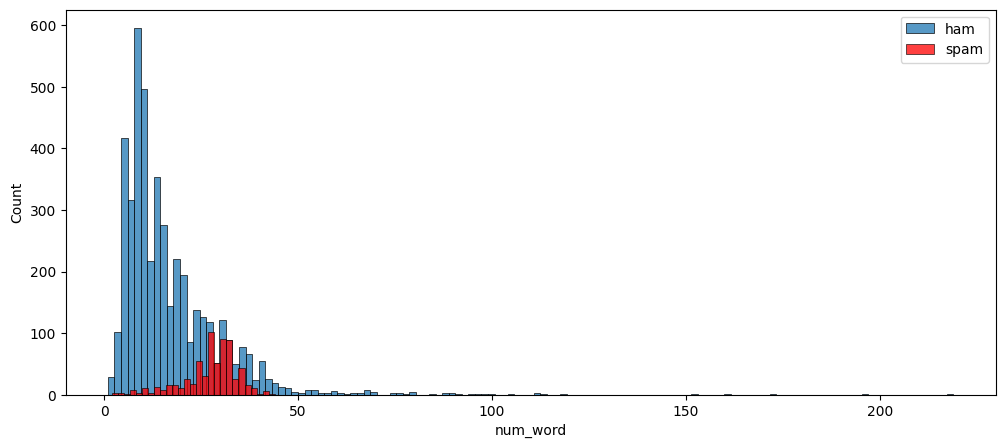

In [22]:
plt.figure(figsize=(12,5))
sns.histplot(df[df.target==0]['num_word'],label='ham')
sns.histplot(df[df.target==1]['num_word'],color='red',label='spam')
plt.legend()
plt.show()

<Axes: >

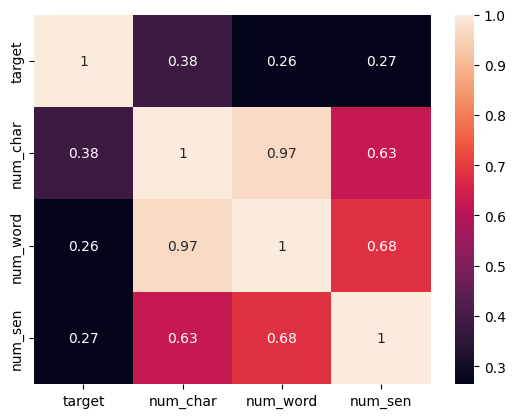

In [23]:
sns.heatmap(df.select_dtypes(include='int').corr(),annot=True)

since char has most correlation with target, we choose num_char for further use

### Text Processing
-Lower Case <br>
-Tokenization <br>
-Removing Special Chars<br>
-Removing stop words and punctuation<br>
-Stemming<br>

In [24]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
import string

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def transform_text(text):
    text=text.lower()
    text=nltk.word_tokenize(text)
    
    y=[]
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text.clear()        
    for i in y:
        if i not in stopwords.words('english') and i not in string.punctuation:
            text.append(i)
            
    y.clear()
    ps=PorterStemmer()
    for i in text:
        y.append(ps.stem(i))
    
    return " ".join(y)

In [26]:
df['transformed_text']=df['text'].apply(transform_text)

In [27]:
df.head()

,target,text,num_char,num_word,num_sen,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [28]:
from wordcloud import WordCloud
wc=WordCloud(width=500,height=500,min_font_size=10,background_color='white')

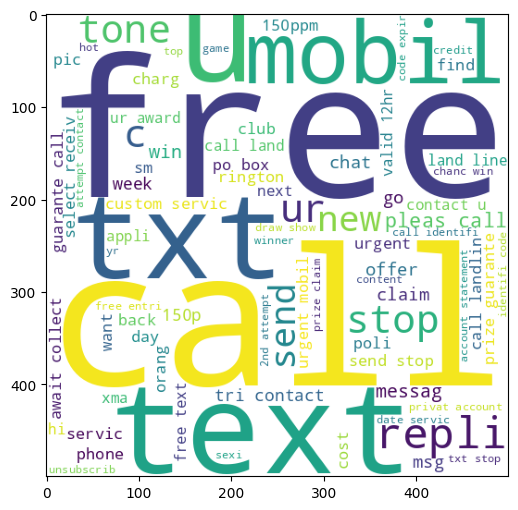

In [29]:
spam_wc=wc.generate(df[df.target==1]['transformed_text'].str.cat(sep=' '))
plt.figure(figsize=(12,6))
plt.imshow(spam_wc)

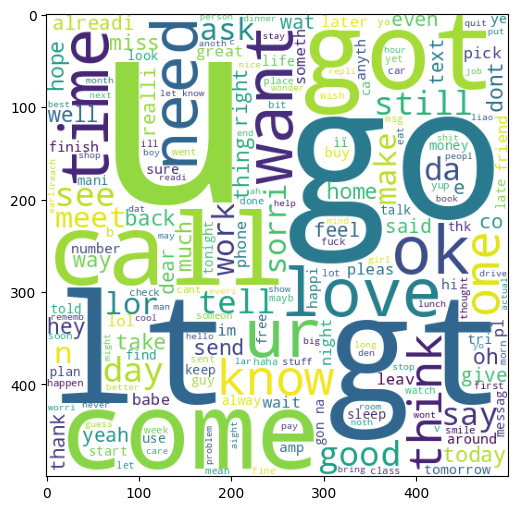

In [30]:
ham_wc=wc.generate(df[df.target==0]['transformed_text'].str.cat(sep=' '))
plt.figure(figsize=(12,6))
plt.imshow(ham_wc)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


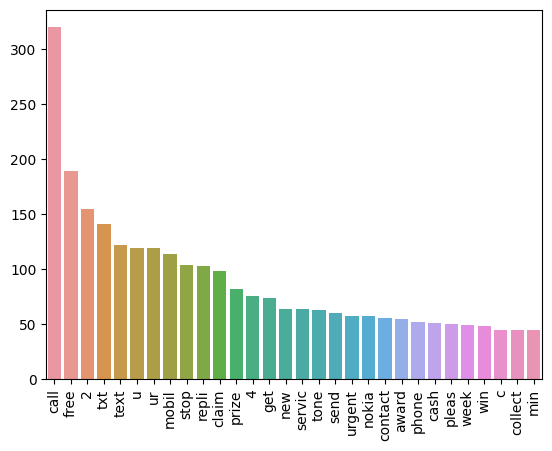

In [31]:
#most ocurring words in spam
y={}
for msg in df[df.target==1].transformed_text.tolist():
    for word in msg.split():
        y[word]=y.get(word,0)+1

sorted_y=sorted(y.items(),key=lambda x:x[1],reverse=True)
top_words = [item[0] for item in sorted_y[:30]]
word_counts = [item[1] for item in sorted_y[:30]]
sns.barplot(x=top_words,y=word_counts)
plt.xticks(rotation='vertical')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


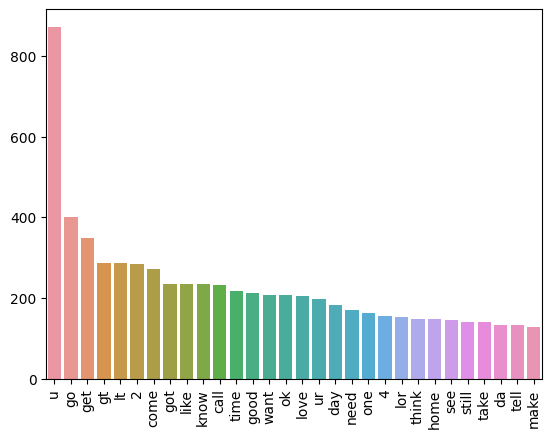

In [32]:
#most ocurring words in spam
y={}
for msg in df[df.target==0].transformed_text.tolist():
    for word in msg.split():
        y[word]=y.get(word,0)+1

sorted_y=sorted(y.items(),key=lambda x:x[1],reverse=True)
top_words = [item[0] for item in sorted_y[:30]]
word_counts = [item[1] for item in sorted_y[:30]]
sns.barplot(x=top_words,y=word_counts)
plt.xticks(rotation='vertical')
plt.show()

### Model Building

In [33]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
#cv = CountVectorizer()  #bag of words
tfidf = TfidfVectorizer(max_features=3000)

In [34]:
#X=cv.fit_transform(df['transformed_text']).toarray()   #returns a sparse matrix
tfidf.fit(df['transformed_text'])
X=tfidf.transform(df['transformed_text']).toarray()

In [35]:
y=df['target']

In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

In [37]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [38]:
gnb=GaussianNB()
mnb=MultinomialNB()
bnb=BernoulliNB()

In [39]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.867504835589942
[[785 111]
 [ 26 112]]
0.5022421524663677


In [40]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9729206963249516
[[896   0]
 [ 28 110]]
1.0


In [41]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9816247582205029
[[895   1]
 [ 18 120]]
0.9917355371900827


Since, precision maters the most here (false positive), we go with mnb

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [43]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [44]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'MNB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [45]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [46]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9748549323017408
Precision -  0.9666666666666667
For  KN
Accuracy -  0.9052224371373307
Precision -  1.0
For  MNB
Accuracy -  0.9729206963249516
Precision -  1.0
For  DT
Accuracy -  0.9313346228239845
Precision -  0.8316831683168316
For  LR
Accuracy -  0.9574468085106383
Precision -  0.9519230769230769
For  RF
Accuracy -  0.971953578336557
Precision -  0.9739130434782609
For  AdaBoost
Accuracy -  0.9642166344294004
Precision -  0.9316239316239316
For  BgC
Accuracy -  0.9545454545454546
Precision -  0.8527131782945736
For  ETC
Accuracy -  0.9777562862669246
Precision -  0.9831932773109243
For  GBDT
Accuracy -  0.9487427466150871
Precision -  0.9292929292929293
For  xgb
Accuracy -  0.9642166344294004
Precision -  0.9243697478991597


In [47]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values(by='Precision',ascending=False)

In [48]:
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.905222,1.000000
2,MNB,0.972921,1.000000
8,ETC,0.977756,0.983193
5,RF,0.971954,0.973913
0,SVC,0.974855,0.966667
4,LR,0.957447,0.951923
6,AdaBoost,0.964217,0.931624
9,GBDT,0.948743,0.929293
10,xgb,0.964217,0.924370
7,BgC,0.954545,0.852713


In [49]:
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

A Voting Classifier is an ensemble learning method that combines the predictions of multiple base estimators (machine learning models) and predicts the class label by taking a vote.

In [50]:
voting = VotingClassifier(estimators=[('svm', svc), ('mnb', mnb), ('etc', etc)],voting='soft')
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('mnb', MultinomialNB()),
                             ('etc',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [51]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9796905222437138
Precision 0.975609756097561


A stacking classifier is an ensemble method where the output from multiple classifiers is passed as an input to a meta-classifier for the task of the final classification.

In [52]:
from sklearn.ensemble import StackingClassifier

In [53]:
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [54]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [55]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9787234042553191
Precision 0.9461538461538461


In [56]:
#best performance is observed in Multinomial-Naive Bayes
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9729206963249516
[[896   0]
 [ 28 110]]
1.0
